In [1]:
!pip install -q datasets trl bitsandbytes

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
import os
import re
import torch
import wandb
from google.colab import userdata
from datetime import datetime
from tqdm import tqdm
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from trl import SFTTrainer, SFTConfig, DataCollatorForCompletionOnlyLM
from peft import PeftModel, LoraConfig
from testing import Tester

In [11]:
BASE_MODEL = "Qwen/Qwen2.5-7B"

HF_USER = "jeffc00"
PROJECT_NAME = "pricer"

DATASET_NAME = "ed-donner/pricer-data"
MAX_SEQUENCE_LENGTH = 300

RUN_NAME = f"{datetime.now():%Y-%m-%d_%H.%M.%S}"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Hyperparameters for QLoRA
LORA_R = 32
LORA_ALPHA = 64
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]
LORA_DROPOUT = 0.1
QUANT_4_BIT = True

# Hyperparameters for Training
EPOCHS = 1
BATCH_SIZE = 8
GRADIENT_ACCUMULATION_STEPS = 1
LEARNING_RATE = 1e-4
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"

STEPS = 50
SAVE_STEPS = 2000
LOG_TO_WANDB = True

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [12]:
# Log in to HuggingFace
hf_token = userdata.get("HF_TOKEN")
login(hf_token, add_to_git_credential=True)

# Log in to Weights & Biases
os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")
wandb.login()

# Configure Weights & Biases to record against our project
os.environ["WANDB_PROJECT"] = PROJECT_NAME
os.environ["WANDB_LOG_MODEL"] = "checkpoint" if LOG_TO_WANDB else "end"
os.environ["WANDB_WATCH"] = "gradients"

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jeffc00 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [32]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [14]:
if LOG_TO_WANDB:
    wandb.init(project=PROJECT_NAME, name=RUN_NAME)

### The model is "quantized" - we are reducing the precision to 4 bits

In [15]:
if QUANT_4_BIT:
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4"
    )
else:
    quant_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_compute_dtype=torch.bfloat16
    )

In [18]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e6:.1f} MB")

model-00002-of-00004.safetensors:   9%|9         | 357M/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Memory footprint: 5443.3 MB


### The trainer needs to teach the model to predict the token(s) after "Price is $"

In [19]:
response_template = "Price is $"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

### Set up the configuration for Training

In [34]:
lora_parameters = LoraConfig(
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    r=LORA_R,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=TARGET_MODULES,
)

train_parameters = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    eval_strategy="no",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    report_to="wandb" if LOG_TO_WANDB else None,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="text",
    save_strategy="steps",
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=True
)

fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=train,
    peft_config=lora_parameters,
    processing_class=tokenizer,
    args=train_parameters,
    data_collator=collator
)

Converting train dataset to ChatML:   0%|          | 0/32000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/32000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/32000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/32000 [00:00<?, ? examples/s]

### Kick off fine-tuning

In [38]:
fine_tuning.train()

# Push our fine-tuned model to Hugging Face
fine_tuning.model.push_to_hub(PROJECT_RUN_NAME, private=True)
print(f"Saved to the hub: {PROJECT_RUN_NAME}")

Step,Training Loss
50,0.874700
100,0.877700
150,0.866800
200,0.865800
250,0.877700
300,0.862300
350,0.884200
400,0.870800
450,0.878700
500,0.870500


wandb: Adding directory to artifact (./pricer-2025-03-01_17.49.37/checkpoint-2000)... Done. 0.3s
wandb: Adding directory to artifact (./pricer-2025-03-01_17.49.37/checkpoint-4000)... Done. 0.6s
No files have been modified since last commit. Skipping to prevent empty commit.


Saved to the hub: pricer-2025-03-01_17.49.37


In [39]:
if LOG_TO_WANDB:
    wandb.finish()

train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train/grad_norm,▄▃▂▂▇▅▄█▄▁▅▂▂▅▅▄▄▂█▄▃▄▂▅▂▂▁▅▆▁▄▂▃▂▃▄▃▄▄▁
train/learning_rate,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
train/loss,▄▃▄▄▅▄▃▄▂▄█▅▅▇▁▆▅▄▆▄▄▂▄▄▅▃▆▄▃▇▂▄▄▃▃▃▇▇▅▆
train/mean_token_accuracy,▅▄▆▅▆▅▃▇▄▆▇▄▆▇▄▆▄▄▆▃▅▇▃▅█▆▆▆▄▆▄▁▅▆▆▂▄▄▅▁
total_flos,2.558128451111977e+17
train/epoch,1
train/global_step,4000
train/grad_norm,0.78889
train/learning_rate,0


### Prediction

In [40]:
RUN_NAME = "2025-03-01_17.49.37"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
REVISION = "c6c8eaba4d7286de9c85f7379b5592b0061395e7"
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

In [41]:
# Load the fine-tuned model with PEFT
if REVISION:
    fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
    fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)

print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Memory footprint: 5524.3 MB


In [42]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(152064, 3584)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3584, out_features=3584, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3584, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=3584, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.

In [43]:
def extract_price(s):
    if "Price is $" in s:
        contents = s.split("Price is $")[1]
        contents = contents.replace(',','')
        match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
        return float(match.group()) if match else 0
    return 0

In [44]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

1: Guess: $320.00 Truth: $374.41 Error: $54.41 SLE: 0.02 Item: OEM AC Compressor w/...
2: Guess: $151.00 Truth: $225.11 Error: $74.11 SLE: 0.16 Item: Motorcraft YB3125 Fa...
3: Guess: $41.00 Truth: $61.68 Error: $20.68 SLE: 0.16 Item: Dorman Front Washer ...
4: Guess: $599.00 Truth: $599.99 Error: $0.99 SLE: 0.00 Item: HP Premium HD Plus T...
5: Guess: $18.00 Truth: $16.99 Error: $1.01 SLE: 0.00 Item: Super Switch Pickup ...
6: Guess: $11.00 Truth: $31.99 Error: $20.99 SLE: 1.02 Item: Horror Bookmarks, Re...
7: Guess: $40.00 Truth: $101.79 Error: $61.79 SLE: 0.84 Item: SK6241 - Stinger 4 G...
8: Guess: $249.00 Truth: $289.00 Error: $40.00 SLE: 0.02 Item: Godox ML60Bi LED Lig...
9: Guess: $600.00 Truth: $635.86 Error: $35.86 SLE: 0.00 Item: Randall G3 Plus Comb...
10: Guess: $110.00 Truth: $65.99 Error: $44.01 SLE: 0.26 Item: HOLDWILL 6 Pack LED ...
11: Guess: $250.00 Truth: $254.21 Error: $4.21 SLE: 0.00 Item: Viking Horns 3 Gallo...
12: Guess: $250.00 Truth: $412.99 Error: $162.99 SLE

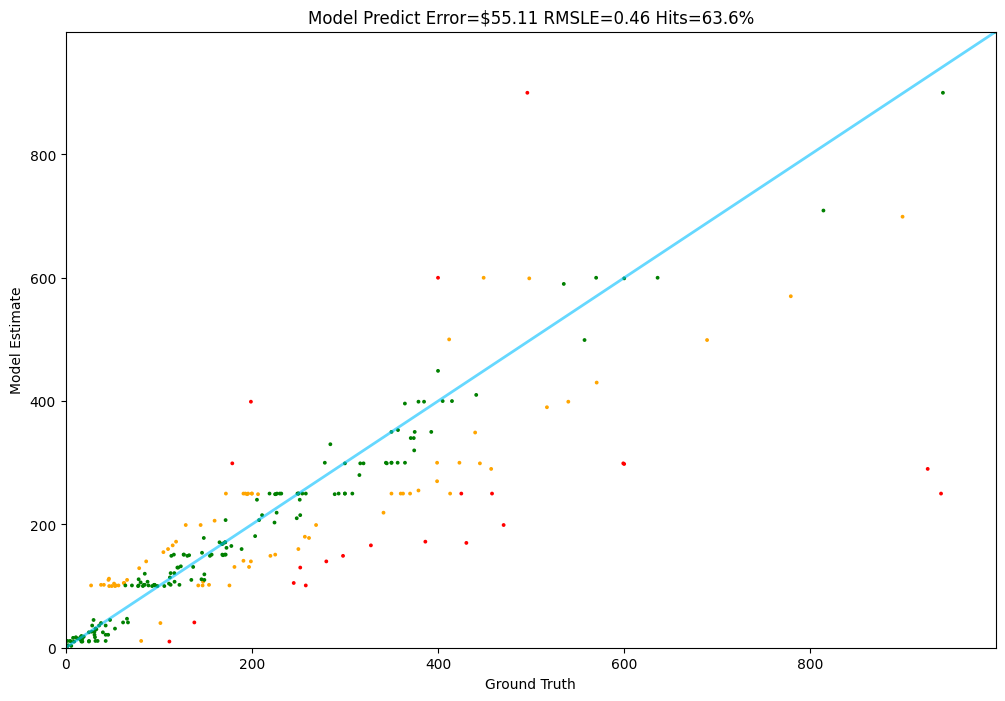

In [45]:
Tester.test(model_predict, test)